<img src="https://farm66.staticflickr.com/65535/49055715328_092031af74_o.png"  width="150" />

### CBPF - Centro Brasileiro de Pesquisas Físicas

# Projeto final do curso de Análise de big data e Astroinformática

### João Paulo Correia de França
### contato: joao.contato505@gmail.com


### Professor: Clécio R. de Bom

In [1]:
import numpy as np
import pandas as pd
from glob import glob
import subprocess
from PIL import Image
import autolens.plot as aplt
import autofit as af
import autolens as al
#from ipywidgets import *

import matplotlib.pyplot as plt
%matplotlib inline

2021-11-18 19:11:24,046 - autoconf.conf - WARNING - Pushing new config with path /home/joao/.local/lib/python3.8/site-packages/autofit/config


2021-11-18 19:11:24,208 - autoconf.conf - WARNING - Pushing new config with path /home/joao/.local/lib/python3.8/site-packages/autogalaxy/config
2021-11-18 19:11:24,504 - autoconf.conf - WARNING - Pushing new config with path /home/joao/.local/lib/python3.8/site-packages/autolens/config


In [2]:
# pixel scale, which represents the conversion rate between pixel^2 and arcsec^2
pixel_scale = 0.263
print('1 pixel² is equivalent to {:4.2f} arcsec²'.format(pixel_scale))

1 pixel² is equivalent to 0.26 arcsec²


In [3]:
# Catalog simulation parameters (true values)
lenses_DESc = pd.read_csv('./lenses_DESc.txt',
                          sep=' ',
                          comment='#',
                          names=['id', 'zl', 'zs', 'b', 'sig_v', 'ql', 'rl', 'lens_g', 'lens_r', 'lens_i', 'xs', 'ys', 'qs', 'ps', 'rs', 'source_g', 'source_r', 'source_i', 'mu_s', 'g_band_coadd_seeing', 'g_band_coadd_signal_to_noise', 'r_band_coadd_seeing', 'r_band_coadd_signal_to_noise', 'i_band_coadd_seeing'])

In [4]:
lenses_DESc.head()

,id,zl,zs,b,sig_v,ql,rl,lens_g,lens_r,lens_i,...,rs,source_g,source_r,source_i,mu_s,g_band_coadd_seeing,g_band_coadd_signal_to_noise,r_band_coadd_seeing,r_band_coadd_signal_to_noise,i_band_coadd_seeing
0,0,0.320,1.784,1.497,265.112,0.771,1.330,19.961,18.086,17.442,...,131.188,0.290,6.413,1.352,37.000,1.352,19.368,1.352,11.432,32.021
1,1,0.402,1.790,1.372,264.665,0.811,0.819,20.778,18.833,18.103,...,35.232,0.408,4.585,1.352,22.528,1.352,11.003,1.352,9.419,19.750
2,3,0.569,1.285,1.361,318.578,0.671,0.853,21.374,19.530,18.255,...,113.910,0.290,8.931,1.352,32.892,1.352,22.761,1.352,16.575,28.284
3,4,0.189,3.385,1.686,257.082,0.709,2.291,18.166,16.757,16.249,...,125.445,0.321,7.212,1.352,23.054,1.352,15.983,1.352,9.900,17.660
4,5,0.568,1.057,0.658,242.661,0.768,0.409,22.679,20.836,19.562,...,53.932,0.008,156.589,1.352,0.002,1.352,21.890,1.352,25.334,0.000


In [5]:
image_data_paths=glob('./LensPop/images/*/')
print('Current strong lensing cutouts on path: {:4.0f}'.format(len(image_data_paths)))

Current strong lensing cutouts on path: 1404


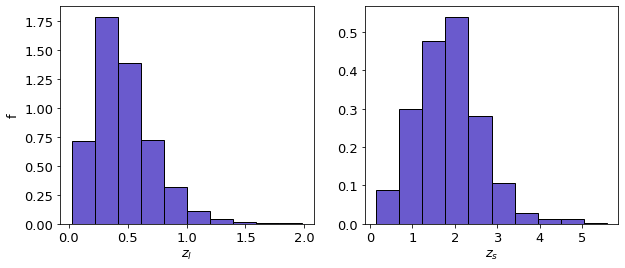

In [6]:
# Redshift distribution of simulated strong lensing systems
 
plt.rcParams.update({"font.size": 13})

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].hist(lenses_DESc["zl"], density=True, ec="k", color="slateblue")
ax[0].set_xlabel("$z_l$")
ax[0].set_ylabel("f")

ax[1].hist(lenses_DESc["zs"], density=True, ec="k", color="slateblue")
ax[1].set_xlabel("$z_s$");

In [7]:
def call_STIFF(File_Path, File_Name, Bits = 16, Gamma_Type = 'REC.709', Gamma = 2.2, \
               Gamma_Fac = 1.0, Colour_Sat = 0., Negative = 'N', Verbose = 'QUIET', Copy_Header = 'N', \
               Write_XML = 'N', NThreads = 4):
    '''
    STIFF def function to build a RGB image from image bands
    
    File_Path: str
        path of the cutouts 
    File_Name: str
        output path of the rgb fits file
    Bits: float, defaut 16
        image bits
    Gamma_Type: str
        Gamma classification, defaut REC.709'
    Gamma: float
        Display gamma, default 2.2
    Gamma_Fac: float
        Luminance gamma correction factor, default 1.0
    Colour_Sat: float
        Colour saturation (0.0 = B&W), default 0.
    Negative: str
         Make negative of the image, default 'N'
    Verbose: str
        Report, default 'Quiet'
    Copy_Header: str
        Copy Header or not?, 'N'
    Write_XML: str
        Write a XML file or not?, default 'N'
    NThread: int
        Parallel processing threads, default 4
    '''
    
    general = f'-OUTFILE_NAME {File_Name} -BITS_PER_CHANNEL {Bits} '
    dynamic_range = f'-GAMMA_TYPE {Gamma_Type} -GAMMA {Gamma} -GAMMA_FAC {Gamma_Fac} -COLOUR_SAT {Colour_Sat} -NEGATIVE {Negative} '
    misc = f'-VERBOSE_TYPE {Verbose} -COPY_HEADER {Copy_Header} -WRITE_XML {Write_XML} -NTHREADS {NThreads} -COMPRESSION_QUALITY 100 -SATUR_LEVEL 100000'
    stiff_call = f'stiff {File_Path} '+general+dynamic_range+misc
    
    # run a subprocess call
    return subprocess.call(stiff_call, shell=True, stderr=subprocess.DEVNULL)

In [8]:
def get_image(image_id):
    '''
    Get image and build an RGB one based on stiff function
    
    image_id: int
        DES-c image id
    lens_sub: bool
        Read subtracted lens image (True) or the original one (False), default True
    '''

    # image in g-bandwidth
    image_g = al.Array2D.from_fits("./LensPop/images/"+str(image_id)+"/galsub_g_SDSS.fits",
                                   pixel_scales=pixel_scale,
                                   hdu=0)
    # image in r-bandwidth
    image_r = al.Array2D.from_fits("./LensPop/images/"+str(image_id)+"/galsub_r_SDSS.fits",
                                   pixel_scales=pixel_scale,
                                   hdu=0)
    # image in i-bandwidth
    image_i = al.Array2D.from_fits("./LensPop/images/"+str(image_id)+"/galsub_i_SDSS.fits",
                                   pixel_scales=pixel_scale,
                                   hdu=0)
    # sigma image in g-bandwidth
    sigma_image_g = al.Array2D.from_fits("./LensPop/images/"+str(image_id)+"/sigma_g_SDSS.fits",
                                         pixel_scales=pixel_scale,
                                         hdu=0)
    # sigma image in r-bandwidth
    sigma_image_r = al.Array2D.from_fits("./LensPop/images/"+str(image_id)+"/sigma_r_SDSS.fits",
                                         pixel_scales=pixel_scale,
                                         hdu=0)
    # sigma image in i-bandwidth
    sigma_image_i = al.Array2D.from_fits("./LensPop/images/"+str(image_id)+"/sigma_i_SDSS.fits",
                                         pixel_scales=pixel_scale,
                                         hdu=0)
    # psf image in g-bandwidth
    psf_g = al.Array2D.from_fits("./LensPop/images/"+str(image_id)+"/psf_g_SDSS.fits",
                                   pixel_scales=pixel_scale,
                                   hdu=0)
    # psf image in r-bandwidth
    psf_r = al.Array2D.from_fits("./LensPop/images/"+str(image_id)+"/psf_r_SDSS.fits",
                                   pixel_scales=pixel_scale,
                                   hdu=0)
    # psf image in i-bandwidth
    psf_i = al.Array2D.from_fits("./LensPop/images/"+str(image_id)+"/psf_i_SDSS.fits",
                                   pixel_scales=pixel_scale,
                                   hdu=0)
    # building our data-lists
    image_al = [image_g, image_r, image_i]
    sigma_al = [sigma_image_g, sigma_image_r, sigma_image_i]
    psf_al = [psf_g, psf_r, psf_i]

    # generate a stiff (RGB) image
    call_STIFF(File_Path = "./LensPop/images/"+str(image_id)+"/galsub_i_SDSS.fits" + " " + \
               "./LensPop/images/"+str(image_id)+"/galsub_r_SDSS.fits" + " " + \
               "./LensPop/images/"+str(image_id)+"/galsub_g_SDSS.fits", File_Name = f"./stiff_systems/"+str(image_id)+".tif", Colour_Sat = 1.)
    # reading a tif image
    im = Image.open("./stiff_systems/"+str(image_id)+".tif")
    #tranforming into an array
    imarray = np.array(im)
    return image_al, sigma_al, psf_al, imarray

In [9]:
# pick up a random seed
np.random.seed(42)

# systems
systems = np.random.randint(low=0,
                            high=len(image_data_paths),
                            size=60)
print('systems: ', systems)

systems_cutouts = []
for i in range(0, len(systems)):
    image_al, sigma_al, psf_al, image_stiff = get_image(int(systems[i]))
    # buiding our cutouts
    systems_cutouts.append([image_al, sigma_al, psf_al, image_stiff])

systems:  [1126  860 1294 1130 1095 1044  121  466 1238  330   87 1396 1123  871
  130 1332  769  343  805  385 1215  955  276 1184  459 1337   21  252
  747  856  474 1082  510  699  975  189  957  686  957  562 1267  831
 1154  646   20  840  166 1297  387  600  315   13  241  776 1369  564
  897 1363   91 1390]


In [ ]:
# ploting GRI and RGB images
fig, ax = plt.subplots(3, 4, figsize=(8, 8))

title = ["SDSSG", "SDSSR", "SDSSI", "RGB"]

for ii in range(0, len(ax)):
    image_al, sigma_al, psf_al, image_stiff = systems_cutouts[ii]
    for jj in range(0, len(ax[ii])):
        if jj < 3:
            ax[ii][jj].imshow(image_al[jj].reshape(76, 76), cmap="gist_gray")
            ax[ii][jj].set_xticks([])
            ax[ii][jj].set_yticks([])
            ax[ii][jj].set_title(title[jj])

        else:
            ax[ii][jj].imshow(image_stiff)
            ax[ii][jj].set_xticks([])
            ax[ii][jj].set_yticks([])
            ax[ii][jj].set_title(title[jj])

In [ ]:
def prepare_image(cutout_data):
    '''
    def function to prepare our data into a PyAutoLens format (imaging object)
    cutout_data: list
        cutout data as [image, sigma image, point spread function, rgb image]
    '''
    
    for ii in range(0, len(cutout_data)):
        image_al, sigma_al, psf_al, image_stiff = systems_cutouts[ii]
        
        # mean image (mean of RGB)
        image = np.mean(image_al, axis=0).reshape(76,76)
        image = al.Array2D.manual(image, pixel_scales=pixel_scale)
        
        # same as image
        sigma = np.mean(sigma_al, axis=0).reshape(76,76)
        sigma = al.Array2D.manual(sigma, pixel_scales=pixel_scale)

        # psf as a Kernel2D, here we reshape into a odd Kernel
        psf = np.mean(psf_al, axis=0).reshape(76,76)
        psf = al.Kernel2D.manual(psf, pixel_scales=pixel_scale)
        trimmed_psf = al.preprocess.array_with_new_shape(array=psf, new_shape=(21, 21))
        
        # imaging object
        cutout_data[ii] = al.Imaging(image=image, psf=trimmed_psf, noise_map=sigma)

    return cutout_data

In [ ]:
# main data array
data = prepare_image(systems_cutouts)

In [ ]:
print("Applying a inverse modeling into our cutouts, please wait...")
for i in range(0, len(systems)):
    print("system: ", systems[i])
    # selecting data
    imaging = data[i]
    # apply a 2D circular mask envolving the strong lensing object it may fail, please verify if its consistent
    mask = al.Mask2D.circular(shape_native=imaging.shape_native,
                              pixel_scales=imaging.pixel_scales,
                              radius=7.)
    imaging = imaging.apply_mask(mask=mask)
    
    # if systems in the lenses DESc:
    if systems[i] in list(lenses_DESc["id"]):
        
        
        # lens and source redshift
        zl, zs = float(lenses_DESc[lenses_DESc["id"]==systems[i]]["zl"]), float(lenses_DESc[lenses_DESc["id"]==systems[i]]["zs"])
        print('Lens redshift and source refshift are, respectively, ', zl, zs)

        print('Building our model')
        # lens galaxy + bulge
        bulge = af.Model(al.lp.EllDevVaucouleurs)
        lens = af.Model(al.Galaxy,
                        redshift=zl,
                        bulge=bulge,
                        mass=al.mp.EllIsothermal)
        # source galaxy
        source = af.Model(al.Galaxy,
                          redshift=zs,
                          disk=al.lp.EllExponential)
        # building our model
        model = af.Collection(galaxies=af.Collection(lens=lens, source=source))

        # Search object
        print('Starting to fit...')
        search = af.DynestyStatic(path_prefix="./",
                                  unique_tag=str(systems[i]),
                                  nlive=50,
                                  number_of_cores=3) # be carefull with this!

        analysis = al.AnalysisImaging(dataset=imaging)

        result = search.fit(model=model, analysis=analysis)
print("Done")